In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, SpatialDropout1D, LSTM, BatchNormalization

from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
#load and examine the data
data=pd.read_csv('all/train.tsv',  sep="\t")
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
data.shape

(156060, 4)

In [5]:
data['Sentiment'].nunique()

5

## Data Analysis
Looking at the data, multiple phrases are generated from a single sentence. 
There are 5 unique output classes or values for sentiments. They correspond to the values:<br>0 - negative<br>1 - somewhat negative<br>2 - neutral<br>3 - somewhat positive<br>4 - positive

In [6]:
print("Total Number of Samples(Phrases) = {}".format(data.shape[0]))
print("Total Number of Sentences = {}".format(len(data['SentenceId'].unique())))
data["Sentiment"].value_counts(sort=False)

Total Number of Samples(Phrases) = 156060
Total Number of Sentences = 8529


0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

As can be seen more phrases are neutral(sentiment 2), followed by somewhat positive or negative (sentiment 1 or 3). Much fewer are strictly positive or negative (sentiment 0 or 4) which makes the job of classification much more difficult. 

Looking at Phrases:


In [7]:
data['Phrase_words'] = data["Phrase"].apply(word_tokenize)
data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_words
0,1,1,A series of escapades demonstrating the adage ...,1,"[A, series, of, escapades, demonstrating, the,..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[A, series, of, escapades, demonstrating, the,..."
2,3,1,A series,2,"[A, series]"
3,4,1,A,2,[A]
4,5,1,series,2,[series]


In [8]:
def get_num_words_per_sample(sample_texts):
    num_words = [len(s) for s in sample_texts]
    return num_words
word_len = get_num_words_per_sample(data['Phrase_words'])
print("Maximum number of words in a Phrase = {}".format(np.max(word_len)))
print("Minimum number of words in a Phrase = {}".format(np.min(word_len)))
print("Mean word length of a Phrase = {0:.3f}".format(np.mean(word_len)))
print("Median word length of a Phrase = {}".format(np.median(word_len)))

Maximum number of words in a Phrase = 53
Minimum number of words in a Phrase = 0
Mean word length of a Phrase = 7.208
Median word length of a Phrase = 5.0


### Data Visualization

Data Samples are distributed among the various classes as follows

Text(0,0.5,'Number of Reviews')

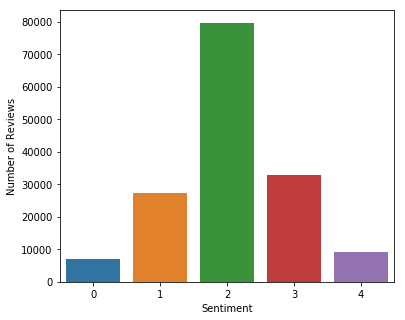

In [9]:
x = np.array(data['Sentiment'].value_counts(sort=False).index)
y = np.array(data['Sentiment'].value_counts(sort=False).values)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

Here is a plot of most frequently occuring words in the data

In [10]:
def plot_frequency_distribution_of_words(sample_texts,
                                          num_words=30):
    # Create args required for vectorizing.
    kwargs = {
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'stop_words' : 'english' #remove the stop words in english
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are words and values are
    # idxices). 
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all words in the index order from the vocabulary.
    all_words = list(vectorizer.get_feature_names())
    num_words = min(num_words, len(all_words))

    # Add up the counts per word ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort words and counts by frequency and get top words.
    all_counts, all_words = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_words), reverse=True)])
    nwords = list(all_words)[:num_words]
    counts = list(all_counts)[:num_words]

    idx = np.arange(num_words)
    plt.figure(figsize=(9,5))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Most Frequently found words')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of words')
    plt.xticks(idx, nwords, rotation=45)
    plt.show()


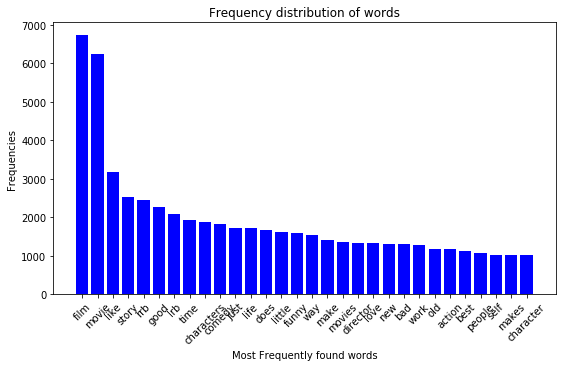

In [11]:
# This shows most frequent words in all the data samples 
plot_frequency_distribution_of_words(data['Phrase'])

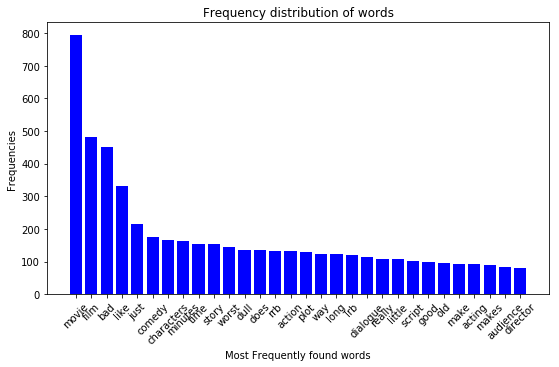

In [12]:
# Most frequent words in Negative Sentiments
neg_data = data[data['Sentiment']==0]
plot_frequency_distribution_of_words(neg_data['Phrase'])

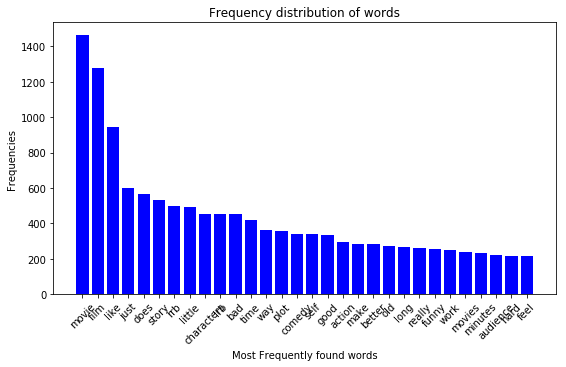

In [13]:
# Most frequent words in Somewhat Negative Sentiments
sneg_data = data[data['Sentiment']==1]
plot_frequency_distribution_of_words(sneg_data['Phrase'])

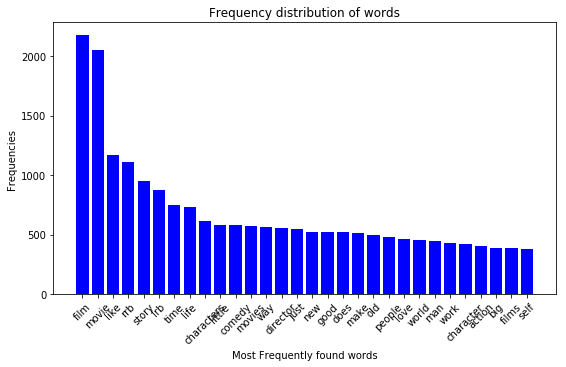

In [14]:
# Most frequent words in Neutral Sentiments
neutral_data = data[data['Sentiment']==2]
plot_frequency_distribution_of_words(neutral_data['Phrase'])

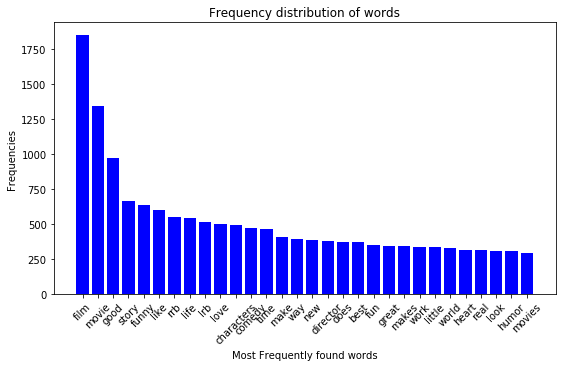

In [15]:
# Most frequent words in Somewhat Positive Sentiments
spos_data = data[data['Sentiment']==3]
plot_frequency_distribution_of_words(spos_data['Phrase'])

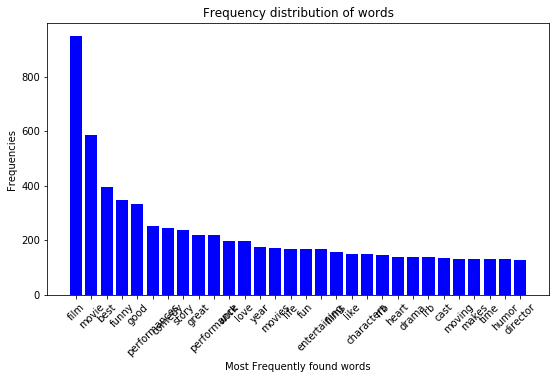

In [16]:
# Most frequent words in Somewhat Positive Sentiments
pos_data = data[data['Sentiment']==4]
plot_frequency_distribution_of_words(pos_data['Phrase'])

Some Observations based on these graphs:
-  Negative reviews include words like bad, worst, dull.
-  Positive reviews include words like best, funny, good, great, love.
-  Neutral reviews have words like story, time, life, characters.<br><br>

### Data Preprocessing


In [17]:
# split data into training and testing set with 75/25 ratio. Also used stratify 
# to maintain the class distribution in training and testing set
all_train = data['Phrase']
y = data["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(data['Phrase'], y, test_size=0.25, 
                                                    random_state = 42, 
                                                    stratify=data['Sentiment'])
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(117045,) (117045,)
(39015,) (39015,)


In [18]:
# Use CountVectorizer to clean the data, remove stop words and generate n-grams 
# Use a maximum of 500 words
count_vec = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,3), 
                            max_features=500)
xtrain_c = count_vec.fit_transform(X_train)
xtest_c = count_vec.fit_transform(X_test)
xtrain_c.shape

(117045, 500)

In [19]:
# Another vectorizer used, which gives normalized results is TF-IDF
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode', # Remove accents during the preprocessing step.
    analyzer='word', 
    stop_words='english', # remove english stop words
    ngram_range=(1, 3), 
    max_features=300000)
vectorizer.fit(all_train)
xtrain_f =  vectorizer.transform(X_train) 
xtest_f =  vectorizer.transform(X_test)

xtrain_f.shape

(117045, 131668)

In [20]:
# Cleaning and Preprocessing Data for Convolutional Neural Networks, remove stopwords, create 
# equal length input sequences and one hot encode them. 
stopwords = set(nltk.corpus.stopwords.words("english"))
max_vocab = 2000
def remove_stopwords(word_list):
    return [word.lower() for word in word_list if word.lower() not in stopwords]

#Add a new column for preprocessing, which tokenizes, removes stopwords and then 
# joins the words back together
data['Phrase_mod'] = data['Phrase'].apply(word_tokenize).apply(remove_stopwords).apply(lambda x: " ".join(x))

data["num_words"] = data["Phrase_mod"].apply(len)
data = data[data["num_words"] > 0]

tokenizer = text.Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data["Phrase_mod"])
x_tokenized=tokenizer.texts_to_sequences(data["Phrase_mod"])
X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(x_tokenized, data['Sentiment'],
                                                                        test_size=0.25, random_state = 42,
                                                                        stratify=data['Sentiment'])


In [21]:
# One hot encode the Phrases and the labels for the Convolutional Neural Network
X_train_conv_cat = tokenizer.sequences_to_matrix(X_train_conv, mode='binary')
X_test_conv_cat = tokenizer.sequences_to_matrix(X_test_conv, mode='binary')
y_train_conv = to_categorical(y_train_conv)
y_test_conv = to_categorical(y_test_conv)
print(X_train_conv_cat.shape, y_train_conv.shape)
print(X_test_conv_cat.shape, y_test_conv.shape)

(116437, 2000) (116437, 5)
(38813, 2000) (38813, 5)


In [22]:
# Loading word2vec embeddings for use in LSTM 
import io
from time import time
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    return data

t1 = time()
embeddings = load_vectors('wiki-news-300d-1M.vec')
t2 = time()
print("Time taken load word2vec = {:.2f}".format(t2-t1))

Time taken load word2vec = 68.52


In [23]:
X_train_seq = {}
X_test_seq = {}


In [24]:
# Further processing for x_tokenized for using the loaded word embeddings 
rnn_tokenizer = text.Tokenizer()
rnn_tokenizer.fit_on_texts(data["Phrase_mod"])
word_index = rnn_tokenizer.word_index
x_tokenized_rnn=tokenizer.texts_to_sequences(data["Phrase_mod"])

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(data["Phrase_mod"], data["Sentiment"], test_size=0.25, 
                                                    random_state = 42, stratify=data['Sentiment'])
#print(X_train_rnn.shape)
# Prepairing data for using the word embeddings in LSTM RNN
X_train_seq = sequence.pad_sequences(rnn_tokenizer.texts_to_sequences(X_train_rnn), maxlen=32)
X_test_seq = sequence.pad_sequences(rnn_tokenizer.texts_to_sequences(X_test_rnn), maxlen=32)

nf = 0
word_nf = []
# Generate mapping for current words using available word2vec model
mapping = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    embed_vec = embeddings.get(word)
    if embed_vec is not None:
        mapping[i] = np.asarray(embed_vec)
    else:
        #print("Embedding not found for '{}'".format(word))
        word_nf.append(word)
        nf += 1
print("Embedding not found for {} word".format(nf))

Embedding not found for 868 word


In [25]:
y_train_rnn = to_categorical(y_train_rnn)
y_test_rnn = to_categorical(y_test_rnn)

### Benchmark Model - Naive Bayes Classifier


In [26]:
cv_accuracy_dict = {}
cv_f1score_dict = {}
tf_accuracy_dict = {}
tf_f1score_dict = {}

def run_and_eval_model(name, cv_model, tf_model, cv_train, tf_train, cv_test, tf_test, 
                       y_tr, y_tst): 
                       #cv_acc_dict, cv_f1_dict, tf_acc_dict, tf_f1_dict):
    t1 = time()
    count_vec_model = cv_model.fit(cv_train, y_tr)
    t2 = time()
    print("Model", name,  "using CountVec fitted in {0:.2f} seconds".format(t2-t1))

    predictionsc = count_vec_model.predict(cv_test)
    acc_score = round((accuracy_score(y_tst, predictionsc) * 100), 3)
    f1_sc = round((f1_score(y_tst, predictionsc, average='weighted')), 3)
    print("Model" , name, "using CountVectorizer Accuracy Score = {0:.3f}".format(acc_score))
    print("& F1 Score = {0:.3f}".format(f1_sc))
    cv_accuracy_dict[name] = acc_score
    cv_f1score_dict[name] = f1_sc

    # Using Tfidf Vectorizer
    t1 = time()
    tf_idf_model = tf_model.fit(tf_train, y_tr)
    t2 = time()
    print("Model", name, "using TfidfVec fitted in {:.2f} seconds".format(t2-t1))

    predictionst = tf_idf_model.predict(tf_test)
    acc_score_t = round((accuracy_score(y_tst, predictionst) * 100), 3)
    f1_score_t = round((f1_score(y_tst, predictionst, average='weighted')), 3)
    print("Model", name, "using TfIdfVectorizer Accuracy Score = {0:.3f}".format(acc_score_t))
    print("& F1 Score = {0:.3f}".format(f1_score_t))
    tf_accuracy_dict[name] = acc_score_t
    tf_f1score_dict[name] = f1_score_t

In [27]:
# Benchmark Model - Multinomial Naive Bayes
run_and_eval_model("NaiveBayes", MultinomialNB(), MultinomialNB(),xtrain_c, xtrain_f, 
                    xtest_c, xtest_f, y_train, y_test)

Model NaiveBayes using CountVec fitted in 0.06 seconds
Model NaiveBayes using CountVectorizer Accuracy Score = 50.891
& F1 Score = 0.403
Model NaiveBayes using TfidfVec fitted in 0.15 seconds
Model NaiveBayes using TfIdfVectorizer Accuracy Score = 61.102
& F1 Score = 0.558


The benchmark model used is __Multinomial Naive Bayes Classifier__.
-  Random guessing gives 20% accuracy
-  Naive Bayes with CountVectorizer gives 50.89% accuracy which is a lot better than random guessing. 
-  Naive Bayes with TfidfVectorizer does much better and gives 61.1% accuracy 
- Let's see how much better we can do with some other Algorithms.


Let's try the following Supervised Learning Classifiers:
 - Logistic Regression
 - Linear Support Vector Machine
 - Random Forest

In [28]:
# Logistic Regression
run_and_eval_model("LogisticRegression", LogisticRegression(), LogisticRegression(),
                    xtrain_c, xtrain_f, xtest_c, xtest_f, y_train, y_test)

Model LogisticRegression using CountVec fitted in 1.56 seconds
Model LogisticRegression using CountVectorizer Accuracy Score = 50.986
& F1 Score = 0.425
Model LogisticRegression using TfidfVec fitted in 2.86 seconds
Model LogisticRegression using TfIdfVectorizer Accuracy Score = 61.697
& F1 Score = 0.573


In [29]:
# Linear Support Vector Machine
run_and_eval_model("LinearSVC", LinearSVC(), LinearSVC(), xtrain_c, xtrain_f, 
                    xtest_c, xtest_f, y_train, y_test)

Model LinearSVC using CountVec fitted in 33.74 seconds
Model LinearSVC using CountVectorizer Accuracy Score = 51.226
& F1 Score = 0.424
Model LinearSVC using TfidfVec fitted in 3.26 seconds
Model LinearSVC using TfIdfVectorizer Accuracy Score = 64.365
& F1 Score = 0.635


In [91]:
# Random Forest Classifier
run_and_eval_model("RandomForest", RandomForestClassifier(random_state=42), RandomForestClassifier(random_state=42),
                    xtrain_c, xtrain_f, xtest_c, xtest_f, y_train, y_test)


Model RandomForest using CountVec fitted in 10.32 seconds
Model RandomForest using CountVectorizer Accuracy Score = 50.145
& F1 Score = 0.427
Model RandomForest using TfidfVec fitted in 1139.83 seconds
Model RandomForest using TfIdfVectorizer Accuracy Score = 63.037
& F1 Score = 0.621


In [92]:
print(cv_accuracy_dict)

{'NaiveBayes': 50.891, 'LogisticRegression': 50.986, 'LinearSVC': 51.226, 'RandomForest': 50.145}


In [93]:
print(tf_accuracy_dict)

{'NaiveBayes': 61.102, 'LogisticRegression': 61.697, 'LinearSVC': 64.365, 'RandomForest': 63.037}


In [51]:
# Neural Network Model Architecture used
input_shape = X_train_conv_cat.shape[1:]
model = Sequential()
model.add(Dropout(rate=0.2, input_shape=input_shape))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_25 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              4098048   
_________________________________________________________________
dropout_26 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 10245     
Total params: 4,108,293
Trainable params: 4,108,293
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compile the model - adam seems to be the best optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [53]:
#Test the accuracy of the model before training, it could be anything close to the random guess
score = model.evaluate(X_test_conv_cat, y_test_conv, verbose = 1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

38813/38813 [==============================] - 5s 123us/step
Test accuracy: 19.9572%


In [114]:
from keras.callbacks import ModelCheckpoint

# Set the model up for ModelCheckPoint, train the model
checkpointer = ModelCheckpoint(filepath='./bestfit', 
                               verbose=1, save_best_only=True)
hist = model.fit(X_train_conv_cat, y_train_conv, batch_size=1500, epochs=20,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 93149 samples, validate on 23288 samples
Epoch 1/20
93149/93149 [==============================] - 18s 190us/step - loss: 1.2047 - acc: 0.5354 - val_loss: 1.0580 - val_acc: 0.5859

Epoch 00001: val_loss improved from inf to 1.05797, saving model to ./bestfit
Epoch 2/20
93149/93149 [==============================] - 16s 170us/step - loss: 1.0322 - acc: 0.6025 - val_loss: 1.0122 - val_acc: 0.6055

Epoch 00002: val_loss improved from 1.05797 to 1.01224, saving model to ./bestfit
Epoch 3/20
93149/93149 [==============================] - 16s 171us/step - loss: 0.9946 - acc: 0.6173 - val_loss: 0.9960 - val_acc: 0.6143

Epoch 00003: val_loss improved from 1.01224 to 0.99600, saving model to ./bestfit
Epoch 4/20
93149/93149 [==============================] - 16s 174us/step - loss: 0.9693 - acc: 0.6287 - val_loss: 0.9840 - val_acc: 0.6168

Epoch 00004: val_loss improved from 0.99600 to 0.98403, saving model to ./bestfit
Epoch 5/20
93149/93149 [==============================] - 16s 172u

In [115]:
# Load the best fit model and find its accuracy on test set
model.load_weights('./bestfit')
score = model.evaluate(X_test_conv_cat, y_test_conv, verbose=1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

38813/38813 [==============================] - 5s 132us/step
Test accuracy: 62.8501%


#### Neural Network Accuracy - 62.85 %

Let's try a Deep Neural Network with an LSTM next:

In [102]:
# Input Layer
input_layer = Input((32,))

# Embedding Layer
embed1 = Embedding(len(word_index) + 1, 300, weights=[mapping], trainable=False)(input_layer)
embed2 = SpatialDropout1D(0.25)(embed1)

# LSTM with dropout
lstm1 = LSTM(256, dropout=0.25)(embed2)

# Batch Normalization
batch1 = BatchNormalization()(lstm1)

# Dense layers with Dropout
d1 = Dense(128, activation="relu")(batch1)
dropout1 = Dropout(0.5)(d1)
d2 = Dense(64, activation="relu")(dropout1)
dropout2 = Dropout(0.25)(d2)
output_layer = Dense(5, activation="softmax")(dropout2)

# Compile the model 
lstm = Model(inputs=input_layer, outputs=output_layer)
lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
lstm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 32, 300)           4567200   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 32, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               570368    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
__________

In [73]:
lstm.fit(X_train_seq, y_train_rnn, batch_size=512, epochs=50)


Epoch 1/50
116437/116437 [==============================] - 123s 1ms/step - loss: 1.1285 - acc: 0.5433
Epoch 2/50
116437/116437 [==============================] - 119s 1ms/step - loss: 1.0108 - acc: 0.5863
Epoch 3/50
116437/116437 [==============================] - 120s 1ms/step - loss: 0.9890 - acc: 0.5950
Epoch 4/50
116437/116437 [==============================] - 120s 1ms/step - loss: 0.9698 - acc: 0.6011
Epoch 5/50
116437/116437 [==============================] - 120s 1ms/step - loss: 0.9593 - acc: 0.6067
Epoch 6/50
116437/116437 [==============================] - 120s 1ms/step - loss: 0.9504 - acc: 0.6107
Epoch 7/50
116437/116437 [==============================] - 120s 1ms/step - loss: 0.9424 - acc: 0.6133
Epoch 8/50
116437/116437 [==============================] - 120s 1ms/step - loss: 0.9326 - acc: 0.6169
Epoch 9/50
116437/116437 [==============================] - 121s 1ms/step - loss: 0.9251 - acc: 0.6188
Epoch 10/50
116437/116437 [==============================] - 120s 1ms/ste

In [101]:
lstm.evaluate(X_test_seq, y_test_rnn)

38813/38813 [==============================] - 24s 622us/step


[0.7900979694910899, 0.673769097961135]

### Accuracy of Deep Neural Network with LSTM = 67.37%

### Result Visualizations

In [30]:
# Plot accuracy scores of top performing models
models = ["NaiveBayes(CV)", "LinearSVC(TV)", "NeuralNetwork", "NN with LSTM"]
accuracy = [50.891, 64.365, 62.85, 67.37]

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

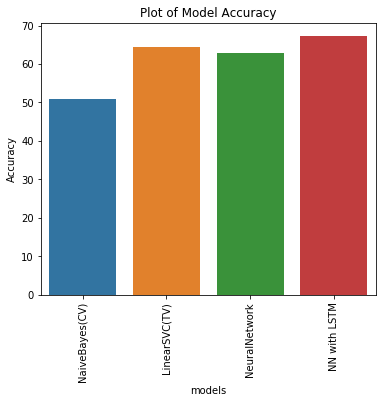

In [31]:
x = np.array(models)
y = np.array(accuracy)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.title('Plot of Model Accuracy')
plt.xlabel('models')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

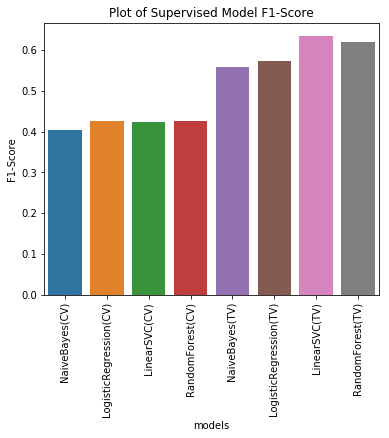

In [32]:
# Plot F1-score of Supervised models
models = ["NaiveBayes(CV)", "LogisticRegression(CV)", "LinearSVC(CV)", "RandomForest(CV)",
          "NaiveBayes(TV)",  "LogisticRegression(TV)", "LinearSVC(TV)", "RandomForest(TV)"]
f1score = [0.403, 0.425, 0.424, 0.427, 0.558, 0.573, 0.635, 0.621]
import seaborn as sns
x = np.array(models)
y = np.array(f1score)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.title('Plot of Supervised Model F1-Score')
plt.xlabel('models')
plt.ylabel('F1-Score')
plt.xticks(rotation=90)

In [33]:
# Plot the accuracy scores of all the models and evaluate the results
models = ["NaiveBayes(CV)", "LogisticReg(CV)", "LinearSVC(CV)", "RandomForest(CV)",
          "NaiveBayes(TV)",  "LogisticReg(TV)", "LinearSVC(TV)", "RandomForest(TV)", 
          "NeuralNetwork", "NN with LSTM"]
accuracy = [50.891, 50.986, 51.226, 50.145, 61.102, 61.697, 64.365, 63.037, 62.85, 67.37]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

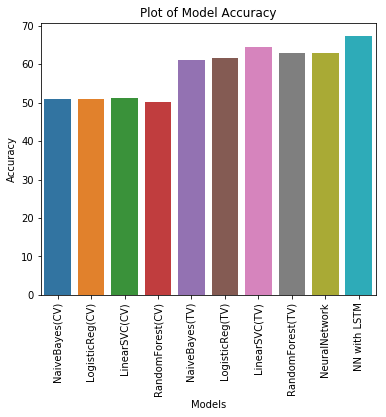

In [34]:
x = np.array(models)
y = np.array(accuracy)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.title('Plot of Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)

#### Some key Observations:
  1. Benchmark Model, Naive Bayes with Count Vectorizer, had an accuracy of 50.89%. The best model in this study was Neural Networks with LSTM which had a 67.37% accuracy. This was a improvement of about 32.4% from the benchmark model.
  2. It also has about 5.9% better accuracy than the best Supervised model and about 8.9% better accuracy than the best Neural Network Model found in this study.
  3. It was observed that Data preprocessed with TfIdfVectorizer performed much better in all the Supervised Learning Algorithms as compared to the CountVectorizer. The accuracy was better by about 10%. The F1-score was also better. 
  4. Neural Networks did not do better. In fact LinearSVC gave a better accuracy.
  5. Also tried many different variations of CNN with Conv1D and MaxPool1D but got very comparable accuracies. So they were not included here in the study. 
  6. LSTM gave the best accuracy, which could be increased by some more parameter tuning.

### Key Results

1. An improvement of about 32.4% in accuracy score was achieved using Neural Networks with LSTM over the Benchmark model of NaiveBayes.
2. Based on the above study it can be said that Neural Networks using the memory retention power of LSTMs is the best model for Sentiment Analysis of a multiclass classification problem.